# Thread Folding

Compute multiple elements per thread, especially in Z direction

In [1]:

import sys 
sys.path.append('../pystencils')
sys.path.append('../genpredict')

%load_ext autoreload
%autoreload 1
%aimport pystencils.warpspeed.warpspeed
%aimport predict
%aimport griditeration
%aimport volumes_isl
%aimport pystencils.astnodes
%aimport plot_utils



In [2]:
from tinydb import TinyDB, Query
db = TinyDB('./db.json')
db.truncate()

In [3]:
import cProfile
import re


import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sys
from subprocess import run, PIPE

from pystencils.transformations import loop_blocking

import pystencils as ps
from pystencils.slicing import add_ghost_layers, make_slice, remove_ghost_layers
from pystencils.warpspeed.warpspeed import PyStencilsWarpSpeedKernel, getFieldExprs, lambdifyExprs, simplifyExprs
from griditeration import *
from volumes_isl import *


from plot_utils import *
from meas_utils import *
from pystencils_stencil_utils import PS3DStencil



import sympy as sp

import pycuda
import pycuda.autoinit
import pycuda.gpuarray as gpuarray
import pycuda.driver as drv

import timeit


In [4]:
size = (600, 600, 512)
SS = PS3DStencil(size, 2)

byte_offset for alignment: 16
byte_offset for alignment: 16


In [5]:
kernel = SS.getStarKernel((16, 16, 2), 2, (1,1,2))

printSASS("#define FUNC_PREFIX __global__\n#define RESTRICT __restrict__\n" + ps.get_code_str(kernel) )

#define FUNC_PREFIX __global__
#define RESTRICT __restrict__
FUNC_PREFIX __launch_bounds__(512) void kernel(double * RESTRICT _data_dst, double * RESTRICT const _data_src)
{
   if (blockDim.x*blockIdx.x + threadIdx.x + 2 < 598 && blockDim.y*blockIdx.y + threadIdx.y + 2 < 598 && 2*blockDim.z*blockIdx.z + 2*threadIdx.z + 2 < 510)
   {
      const int64_t ctr_0 = blockDim.x*blockIdx.x + threadIdx.x + 2;
      const int64_t ctr_1 = blockDim.y*blockIdx.y + threadIdx.y + 2;
      const int64_t ctr_2 = 2*blockDim.z*blockIdx.z + 2*threadIdx.z + 2;
      double * RESTRICT _data_src_10_2m2 = _data_src + 600*ctr_1 + 360000*ctr_2 - 720000;
      const double fa_12 = _data_src_10_2m2[ctr_0];
      double * RESTRICT _data_src_10_2m1 = _data_src + 600*ctr_1 + 360000*ctr_2 - 360000;
      const double fa_2 = _data_src_10_2m1[ctr_0];
      double * RESTRICT _data_src_1m2_20 = _data_src + 600*ctr_1 + 360000*ctr_2 - 1200;
      const double fa_9 = _data_src_1m2_20[ctr_0];
      double * RESTRICT _data_sr

In [6]:
import copy
import sympy as sp
from pystencils.data_types import TypedSymbol, get_type_of_expression
import pystencils.astnodes as astn
blockCount = 2

ast = ps.create_kernel(SS.getStarAssignments(1), target="gpu")

innerBlock =  ast.body._nodes[0].true_block
nodes = innerBlock._nodes

#storeExprs = []
#for n in nodes:
#    if isinstance(n.lhs, TypedSymbol):
#       assignments.append(n)
#    else:
#        storeExprs.append(n)
        
#storeStubs = []
#for s in storeExprs:
#    tempSymbol = TypedSymbol( str(s.lhs.base) + "_" + str(s.lhs.indices[0]), get_type_of_expression(s.rhs) )
#    assignments.append(ps.Assignment(tempSymbol, s.rhs))
#    storeStubs.append(ps.Assignment(s.lhs, tempSymbol))
    


newNodes = []

for block in range(blockCount):
    blockNodes = []
    symbols = [n.lhs for n in nodes]
    new_symbols = [ps.TypedSymbol( n.name + "_b"  + str(block), n.dtype)  for n in symbols if isinstance(n, ps.TypedSymbol)]    
    
    for n in nodes:
        print(n)
        blockNodes.append( astn.SympyAssignment(n.lhs.subs( [*zip(symbols, new_symbols)] ), 
                                         n.rhs.subs( [*zip(symbols, new_symbols)] )))
        print(blockNodes[-1])
        print()
    for n in blockNodes:
        if isinstance(n.lhs, astn.ResolvedFieldAccess):
            n.lhs = astn.ResolvedFieldAccess(n.lhs.base.subs([*zip(symbols, new_symbols)]), n.lhs.indices[0], n.lhs.field, n.lhs.offsets, n.lhs.idx_coordinate_values)
            
    newNodes.extend(blockNodes)
    print()
print()
ast.body._nodes[0].true_block = astn.Block(newNodes)

print(ast.body._nodes[0].true_block)

print(ast.__dict__)

#kernel = ast.compile()    
ps.show_code(ast)


ctr_0 ← blockDim.x*blockIdx.x + threadIdx.x + 1
ctr_0_b0 ← blockDim.x*blockIdx.x + threadIdx.x + 1

ctr_1 ← blockDim.y*blockIdx.y + threadIdx.y + 1
ctr_1_b0 ← blockDim.y*blockIdx.y + threadIdx.y + 1

ctr_2 ← blockDim.z*blockIdx.z + threadIdx.z + 1
ctr_2_b0 ← blockDim.z*blockIdx.z + threadIdx.z + 1

_data_src_10_2m1 ← _data_src + 600*ctr_1 + 360000*ctr_2 - 360000
_data_src_10_2m1_b0 ← _data_src + 600*ctr_1_b0 + 360000*ctr_2_b0 - 360000

fa_4 ← _data_src_10_2m1[ctr_0]
fa_4_b0 ← _data_src_10_2m1[ctr_0_b0]

_data_src_1m1_20 ← _data_src + 600*ctr_1 + 360000*ctr_2 - 600
_data_src_1m1_20_b0 ← _data_src + 600*ctr_1_b0 + 360000*ctr_2_b0 - 600

fa_1 ← _data_src_1m1_20[ctr_0]
fa_1_b0 ← _data_src_1m1_20[ctr_0_b0]

_data_src_10_20 ← _data_src + 600*ctr_1 + 360000*ctr_2
_data_src_10_20_b0 ← _data_src + 600*ctr_1_b0 + 360000*ctr_2_b0

fa_5 ← _data_src_10_20[ctr_0 - 1]
fa_5_b0 ← _data_src_10_20[ctr_0_b0 - 1]

fa_6 ← _data_src_10_20[ctr_0]
fa_6_b0 ← _data_src_10_20[ctr_0_b0]

fa_3 ← _data_src_10_20[ctr

FUNC_PREFIX __launch_bounds__(256) void kernel(double * RESTRICT _data_dst, double * RESTRICT const _data_src, double * RESTRICT const _data_src_10_20, double * RESTRICT const _data_src_10_21, double * RESTRICT const _data_src_10_2m1, double * RESTRICT const _data_src_11_20, double * RESTRICT const _data_src_1m1_20)
{
   if (blockDim.x*blockIdx.x + threadIdx.x + 1 < 599 && blockDim.y*blockIdx.y + threadIdx.y + 1 < 599 && blockDim.z*blockIdx.z + threadIdx.z + 1 < 511)
   {
      const int64_t ctr_0_b0 = blockDim.x*blockIdx.x + threadIdx.x + 1;
      const int64_t ctr_1_b0 = blockDim.y*blockIdx.y + threadIdx.y + 1;
      const int64_t ctr_2_b0 = blockDim.z*blockIdx.z + threadIdx.z + 1;
      const double * RESTRICT _data_src_10_2m1_b0 = _data_src + 600*ctr_1_b0 + 360000*ctr_2_b0 - 360000;
      const double fa_4_b0 = _data_src_10_2m1[ctr_0_b0];
      const double * RESTRICT _data_src_1m1_20_b0 = _data_src + 600*ctr_1_b0 + 360000*ctr_2_b0 - 600;
      const double fa_1_b0 = _data_src_1m1_20[ctr_0_b0];
      const double * RESTRICT _data_src_10_20_b0 = _data_src + 600*ctr_1_b0 + 360000*ctr_2_b0;
      const double fa_5_b0 = _data_src_10_20[ctr_0_b0 - 1];
      const double fa_6_b0 = _data_src_10_20[ctr_0_b0];
      const double fa_3_b0 = _data_src_10_20[ctr_0_b0 + 1];
      const double * RESTRICT _data_src_11_20_b0 = _data_src + 600*ctr_1_b0 + 360000*ctr_2_b0 + 600;
      const double fa_2_b0 = _data_src_11_20[ctr_0_b0];
      const double * RESTRICT _data_src_10_21_b0 = _data_src + 600*ctr_1_b0 + 360000*ctr_2_b0 + 360000;
      const double fa_0_b0 = _data_src_10_21[ctr_0_b0];
      const double * RESTRICT _data_dst_10_20_b0 = _data_dst + 600*ctr_1_b0 + 360000*ctr_2_b0;
      _data_dst_10_20_b0[ctr_0_b0] = fa_0_b0*0.25 + fa_1_b0*0.25 + fa_2_b0*0.25 + fa_3_b0*0.25 + fa_4_b0*0.25 + fa_5_b0*0.25 + fa_6_b0*0.25;
      const int64_t ctr_0_b1 = blockDim.x*blockIdx.x + threadIdx.x + 1;
      const int64_t ctr_1_b1 = blockDim.y*blockIdx.y + threadIdx.y + 1;
      const int64_t ctr_2_b1 = blockDim.z*blockIdx.z + threadIdx.z + 1;
      const double * RESTRICT _data_src_10_2m1_b1 = _data_src + 600*ctr_1_b1 + 360000*ctr_2_b1 - 360000;
      const double fa_4_b1 = _data_src_10_2m1[ctr_0_b1];
      const double * RESTRICT _data_src_1m1_20_b1 = _data_src + 600*ctr_1_b1 + 360000*ctr_2_b1 - 600;
      const double fa_1_b1 = _data_src_1m1_20[ctr_0_b1];
      const double * RESTRICT _data_src_10_20_b1 = _data_src + 600*ctr_1_b1 + 360000*ctr_2_b1;
      const double fa_5_b1 = _data_src_10_20[ctr_0_b1 - 1];
      const double fa_6_b1 = _data_src_10_20[ctr_0_b1];
      const double fa_3_b1 = _data_src_10_20[ctr_0_b1 + 1];
      const double * RESTRICT _data_src_11_20_b1 = _data_src + 600*ctr_1_b1 + 360000*ctr_2_b1 + 600;
      const double fa_2_b1 = _data_src_11_20[ctr_0_b1];
      const double * RESTRICT _data_src_10_21_b1 = _data_src + 600*ctr_1_b1 + 360000*ctr_2_b1 + 360000;
      const double fa_0_b1 = _data_src_10_21[ctr_0_b1];
      const double * RESTRICT _data_dst_10_20_b1 = _data_dst + 600*ctr_1_b1 + 360000*ctr_2_b1;
      _data_dst_10_20_b1[ctr_0_b1] = fa_0_b1*0.25 + fa_1_b1*0.25 + fa_2_b1*0.25 + fa_3_b1*0.25 + fa_4_b1*0.25 + fa_5_b1*0.25 + fa_6_b1*0.25;
   } 
}

In [7]:
predValues = dict()
measValues = dict()
kernelCache = dict()
wsKernelCache = dict()

In [8]:

xticks = []
xtickLabels = []
xtickCounter = 0

print()
print( "                      mem     mem      L2      L2")
print( "                     load   store    load   store       L1")
print()


for r in [2]:
    for blocking_factors in [(1,1,1), (1,1,2), (1,1,4)]:
        for xblock in [4, 8, 16, 32, 64, 128, 256]:
            for yblock in [1, 2, 4, 8, 16, 32, 64, 256]:
                for zblock in [1, 2, 4, 8, 16]:
                    if xblock*yblock*zblock not in [1024]:
                        continue

                    block = (xblock, yblock, zblock)
                    key = (r, *block, *blocking_factors)

                    print("block:" + str(block))
                    print("blocking_factors:" + str(blocking_factors))
                    
                    User = Query()
                    records = db.search((User.block==list(block)) &
                                    (User.range==r) & (User.dim == 3) & 
                                    (User.device=="V100") & 
                                    (User.blocking_factors==list(blocking_factors)) )
                    if(len(records) > 0):
                        print()
                        continue
                    
                    
                    if key in kernelCache:
                        kernel = kernelCache[key]
                    else:             
                        kernel = SS.getStarKernel(block, r, blocking_factors)
                        kernelCache[key] = kernel


                    if key in wsKernelCache:
                        wsKernel = wsKernelCache[key]
                    else:                   
                        wsKernel = PyStencilsWarpSpeedKernel(kernel.ast)     
                        wsKernel.registers = kernel.num_regs
                        wsKernelCache[key] = wsKernel

                    runFunc = SS.getRunFunc(kernel)

                    grid = tuple( (SS.size[i]) // block[i] for i in range(3))

                  
                    print("Registers: " + str(kernel.num_regs))
                    predV = getVolumes(wsKernel, block, grid, (r, r, r, *SS.size), blocking_factors)
                    if not key in measValues:
                        measV = measureMetrics(runFunc, SS.size)
                    else:
                        measV = measValues[key]

                    print("r={}  {:12}   {:5.2f}   {:5.2f}   {:5.2f}   {:5.2f}".format(r, str(block), measV["memLoad"], measV["memStore"], measV["L2Load"], measV["L2Store"] ))
                    print("            {:5.2f} / {:4.2f}   {:5.2f}   {:5.2f}   {:5.2f}   {:6.1f}".format(predV["memLoad"], predV["memLoadISL"], predV["memStore"], predV["L2Load"], predV["L2Store"], predV["L1cycles"]))


                    key = (r, *block)
                    predValues[key] = predV
                    measValues[key] = measV            

                    User = Query()
                    db.upsert({  "sort": "ordered", "block" : block, "range": r, "dim" : 3, "device" : "V100", "blocking_factors" : blocking_factors, "stype" : "star",
                              "mMemLoad" : measV["memLoad"], "mMemStore" : measV["memStore"], "mL2Load" : measV["L2Load"], "mL2Store" : measV["L2Store"],
                               "pL1LoadAllocated" : predV["L1AllocatedLoad"], "pL1Load" : predV["L1Load"], "pL1WarpLoad" : predV["L1WarpLoad"], "pL2Load" : predV["L2Load"], "pL2LoadExt" : predV["L2LoadExt"], "pL2Store" : predV["L2Store"],
                              "pMemLoad" : predV["memLoad"], "pMemLoadISL" : predV["memLoadISL"],"pMemLoadISLext" : predV["memLoadISLext"],  "pMemStore" : predV["memStore"], "pL2LoadAllocated" : predV["L2LoadAllocated"]},
                              (User.block==list(block)) & (User.range==r) & (User.dim == 3) & (User.device=="V100") & (User.blocking_factors==list(blocking_factors)) &  (User.stype=="star"))                

                    #print((measV["memStore"] - predV["memStore"]) / (predV["L2Store"] - predV["memStore"]))
                    print()


                      mem     mem      L2      L2
                     load   store    load   store       L1

block:(4, 16, 16)
blocking_factors:(1, 1, 1)
Registers: 32
Blocks per SM: 2
Concurrent Grid: (149, 1, 1)
Lups/Block: 2048
(4, 8, 1)
1920
ISL Meta Grid:(1, 37, 31)
Allocated L1 Volume / SM: 128 kB
L1 Load Volume: 136 B / Lup
L1 Warp Load Volume: 60 B / Lup
L1 capacity miss: 1.7 B/Lup
Load Data Volumes (new, old, overlap): 1935  1935  321 kb
Store Data Volumes (mem, L2, evicted): 1280 1280 0 kb  
[596, 596, 508]
(149, 38, 32)
1444081472.0
r=2  (4, 16, 16)    10.20    8.00   30.17    8.00
            12.06 / 10.09    8.00   28.00    8.00     60.0

block:(4, 32, 8)
blocking_factors:(1, 1, 1)
Registers: 32
Blocks per SM: 2
Concurrent Grid: (149, 1, 1)
Lups/Block: 2048
(4, 8, 1)
1920
ISL Meta Grid:(1, 18, 63)
Allocated L1 Volume / SM: 136 kB
L1 Load Volume: 136 B / Lup
L1 Warp Load Volume: 60 B / Lup
L1 capacity miss: 3.1 B/Lup
Load Data Volumes (new, old, overlap): 2096  2096  161 

[596, 596, 508]
(19, 149, 64)
1444112096.0
r=2  (32, 4, 8)     12.17    8.00   22.44    8.00
            13.11 / 12.10    8.00   22.00    8.00     28.0

block:(32, 8, 4)
blocking_factors:(1, 1, 1)
Registers: 32
Blocks per SM: 2
Concurrent Grid: (18, 8, 1)
Lups/Block: 2048
(32, 1, 1)
2368
ISL Meta Grid:(1, 10, 127)
Allocated L1 Volume / SM: 58 kB
L1 Load Volume: 108 B / Lup
L1 Warp Load Volume: 74 B / Lup
L1 capacity miss: 0.0 B/Lup
Load Data Volumes (new, old, overlap): 2658  2658  80 kb
Store Data Volumes (mem, L2, evicted): 1280 1280 0 kb  
[596, 596, 508]
(19, 75, 127)
1443790912.0
r=2  (32, 8, 4)     16.17    8.00   22.53    8.00
            16.61 / 16.18    8.00   22.00    8.00     28.0

block:(32, 16, 2)
blocking_factors:(1, 1, 1)
Registers: 32
Blocks per SM: 2
Concurrent Grid: (18, 8, 1)
Lups/Block: 2048
(32, 1, 1)
2368
ISL Meta Grid:(1, 5, 254)
Allocated L1 Volume / SM: 73 kB
L1 Load Volume: 108 B / Lup
L1 Warp Load Volume: 74 B / Lup
L1 capacity miss: 0.0 B/Lup
Load Data Volum

[596, 596, 508]
(3, 149, 508)
1444985696.0
r=2  (256, 4, 1)    40.28    8.01   48.48    8.00
            40.23 / 40.34    8.00   48.25    8.00     28.0

block:(4, 16, 16)
blocking_factors:(1, 1, 2)
Registers: 32
Blocks per SM: 2
Concurrent Grid: (149, 1, 1)
Lups/Block: 4096
(4, 8, 1)
2816
ISL Meta Grid:(1, 37, 31)
Allocated L1 Volume / SM: 240 kB
L1 Load Volume: 120 B / Lup
L1 Warp Load Volume: 44 B / Lup
L1 capacity miss: 12.4 B/Lup
Load Data Volumes (new, old, overlap): 3549  3549  642 kb
Store Data Volumes (mem, L2, evicted): 2560 2560 0 kb  
[596, 596, 254]
(149, 38, 16)
1444132448.0
r=2  (4, 16, 16)    11.76    8.00   40.73    8.00
            11.06 / 10.71    8.00   27.00    8.00    104.0

block:(4, 32, 8)
blocking_factors:(1, 1, 2)
Registers: 32
Blocks per SM: 2
Concurrent Grid: (149, 1, 1)
Lups/Block: 4096
(4, 8, 1)
2816
ISL Meta Grid:(1, 18, 63)
Allocated L1 Volume / SM: 240 kB
L1 Load Volume: 120 B / Lup
L1 Warp Load Volume: 44 B / Lup
L1 capacity miss: 12.4 B/Lup
Load Data V

[596, 596, 254]
(19, 149, 32)
1443667360.0
r=2  (32, 4, 8)     11.32    8.00   22.85    8.00
            11.11 / 10.99    8.00   20.00    8.00     48.0

block:(32, 8, 4)
blocking_factors:(1, 1, 2)
Registers: 32
Blocks per SM: 2
Concurrent Grid: (18, 8, 1)
Lups/Block: 4096
(32, 1, 1)
3712
ISL Meta Grid:(1, 10, 127)
Allocated L1 Volume / SM: 96 kB
L1 Load Volume: 92 B / Lup
L1 Warp Load Volume: 58 B / Lup
L1 capacity miss: 0.0 B/Lup
Load Data Volumes (new, old, overlap): 4032  4032  161 kb
Store Data Volumes (mem, L2, evicted): 2560 2560 0 kb  
[596, 596, 254]
(19, 75, 64)
1443746720.0
r=2  (32, 8, 4)     12.87    8.00   19.79    8.00
            12.61 / 12.60    8.00   18.00    8.00     48.0

block:(32, 16, 2)
blocking_factors:(1, 1, 2)
Registers: 32
Blocks per SM: 2
Concurrent Grid: (18, 8, 1)
Lups/Block: 4096
(32, 1, 1)
3712
ISL Meta Grid:(1, 5, 254)
Allocated L1 Volume / SM: 106 kB
L1 Load Volume: 92 B / Lup
L1 Warp Load Volume: 58 B / Lup
L1 capacity miss: 0.0 B/Lup
Load Data Volume

[596, 596, 254]
(3, 149, 254)
1444241696.0
r=2  (256, 4, 1)    26.34    8.00   34.42    8.00
            24.23 / 24.27    8.00   32.25    8.00     48.0

block:(4, 16, 16)
blocking_factors:(1, 1, 4)
Registers: 31
Blocks per SM: 2
Concurrent Grid: (149, 1, 1)
Lups/Block: 8192
(4, 8, 1)
4608
ISL Meta Grid:(1, 37, 31)
Allocated L1 Volume / SM: 464 kB
L1 Load Volume: 112 B / Lup
L1 Warp Load Volume: 36 B / Lup
L1 capacity miss: 17.0 B/Lup
Load Data Volumes (new, old, overlap): 6777  6777  1284 kb
Store Data Volumes (mem, L2, evicted): 5120 5120 0 kb  
[596, 596, 127]
(149, 38, 8)
1444673536.0
r=2  (4, 16, 16)    27.52    8.01   59.61    8.00
            10.56 / 10.59    8.00   26.50    8.00    192.0

block:(4, 32, 8)
blocking_factors:(1, 1, 4)
Registers: 31
Blocks per SM: 2
Concurrent Grid: (149, 1, 1)
Lups/Block: 8192
(4, 8, 1)
4608
ISL Meta Grid:(1, 18, 63)
Allocated L1 Volume / SM: 448 kB
L1 Load Volume: 112 B / Lup
L1 Warp Load Volume: 36 B / Lup
L1 capacity miss: 16.9 B/Lup
Load Data V

[596, 596, 127]
(19, 149, 16)
1443629920.0
r=2  (32, 4, 8)     12.18    8.00   25.27    8.00
            10.11 / 10.09    8.00   19.00    8.00     88.0

block:(32, 8, 4)
blocking_factors:(1, 1, 4)
Registers: 31
Blocks per SM: 2
Concurrent Grid: (18, 8, 1)
Lups/Block: 8192
(32, 1, 1)
6400
ISL Meta Grid:(1, 10, 127)
Allocated L1 Volume / SM: 172 kB
L1 Load Volume: 84 B / Lup
L1 Warp Load Volume: 50 B / Lup
L1 capacity miss: 7.5 B/Lup
Load Data Volumes (new, old, overlap): 6779  6779  321 kb
Store Data Volumes (mem, L2, evicted): 5120 5120 0 kb  
[596, 596, 127]
(19, 75, 32)
1443613472.0
r=2  (32, 8, 4)     12.05    8.00   20.18    8.00
            10.61 / 10.59    8.00   16.00    8.00     88.0

block:(32, 16, 2)
blocking_factors:(1, 1, 4)
Registers: 31
Blocks per SM: 2
Concurrent Grid: (18, 8, 1)
Lups/Block: 8192
(32, 1, 1)
6400
ISL Meta Grid:(1, 5, 254)
Allocated L1 Volume / SM: 172 kB
L1 Load Volume: 84 B / Lup
L1 Warp Load Volume: 50 B / Lup
L1 capacity miss: 7.5 B/Lup
Load Data Volum

[596, 596, 127]
(3, 149, 127)
1443650336.0
r=2  (256, 4, 1)    17.26    8.00   25.59    8.00
            16.23 / 16.24    8.00   24.25    8.00     88.0



90
{'sort': 'ordered', 'block': [4, 16, 16], 'range': 2, 'dim': 3, 'device': 'V100', 'blocking_factors': [1, 1, 1], 'stype': 'star', 'mMemLoad': 10.203175213431189, 'mMemStore': 8.00268023679149, 'mL2Load': 30.167769984114358, 'mL2Store': 8.000007980061904, 'pL1LoadAllocated': 131072.0, 'pL1Load': 136.0, 'pL1WarpLoad': 60.0, 'pL2Load': 28.0, 'pL2LoadExt': 29.6875, 'pL2Store': 8.0, 'pMemLoad': 12.057046979865772, 'pMemLoadISL': 10.087542087542086, 'pMemLoadISLext': 10.087542087542086, 'pMemStore': 8.0, 'pL2LoadAllocated': 2963462.8956228956}


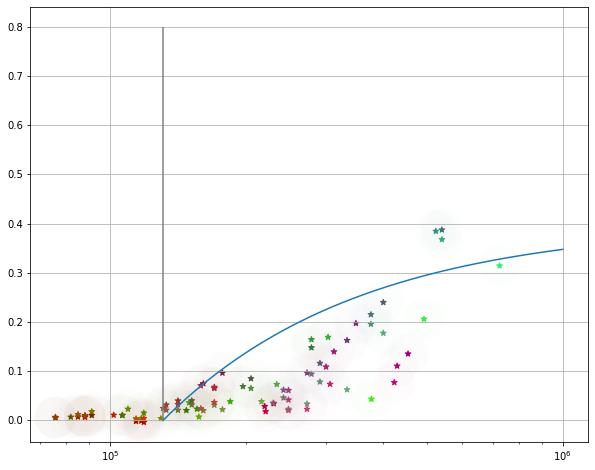

In [20]:
User = Query()
records = db.search(User.range>0)
print(len(records))
print(records[0])

L1AllocatedVolumes = [d["pL1LoadAllocated"] + 2048 * d["blocking_factors"][2]*8 for d in records]
L2LoadCapacitySpillRatio = [ (d["mL2Load"] - d["pL2Load"]) / ((d["pL1Load"])  - d["pL2Load"])  for d in records]
colors = [( math.log(d["block"][0])/7 , math.log(d["block"][1]) / 6, math.log(d["blocking_factors"][2])/3) for d in records ]
#colors = [(1,0,0) if d["sort"] == "random" else ((0,1,0) if d["sort"] == "ordered" else (0,0,1)) for d in records]

ax,fig = plt.subplots(figsize=(10,8))
plt.scatter(L1AllocatedVolumes, L2LoadCapacitySpillRatio, marker="*", c = colors)
plt.scatter(L1AllocatedVolumes, L2LoadCapacitySpillRatio, marker="o", c = colors, s = [1729] * len(colors), alpha=0.01, edgecolors="None")
plt.vlines(128*1024, 0, 0.8, color="gray")
plt.grid()
plt.xscale("log")
points = np.arange(128*1024, 1000000, 4096)
plt.plot( points,   (points - 128*1024) / points *0.4 ) 




#for e in db.search(User.pL1LoadAllocated > 200*1024):
#    print(e)

90
{'sort': 'ordered', 'block': [4, 16, 16], 'range': 2, 'dim': 3, 'device': 'V100', 'blocking_factors': [1, 1, 1], 'stype': 'star', 'mMemLoad': 10.203175213431189, 'mMemStore': 8.00268023679149, 'mL2Load': 30.167769984114358, 'mL2Store': 8.000007980061904, 'pL1LoadAllocated': 131072.0, 'pL1Load': 136.0, 'pL1WarpLoad': 60.0, 'pL2Load': 28.0, 'pL2LoadExt': 29.6875, 'pL2Store': 8.0, 'pMemLoad': 12.057046979865772, 'pMemLoadISL': 10.087542087542086, 'pMemLoadISLext': 10.087542087542086, 'pMemStore': 8.0, 'pL2LoadAllocated': 2963462.8956228956}


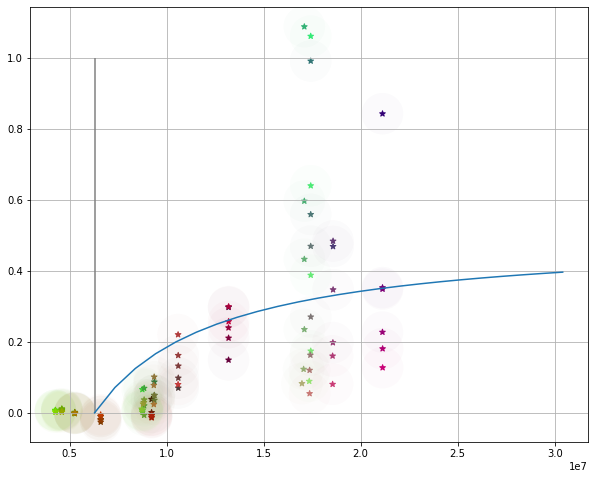

In [10]:
User = Query()
records = db.search(User.range>0)
print(len(records))
print(records[0])

L2Volumes = [d["pL2LoadAllocated"] + d["pMemStore"] * 80 * 2048 * d["blocking_factors"][2] for d in records]
MemLoadCapacitySpillRatio = [ (d["mMemLoad"] - d["pMemLoadISL"]) / (d["pL2Load"]- d["pMemLoad"] )  for d in records]
colors = [( math.log(d["block"][0]) / 7 , math.log(d["block"][2]) / 3, math.log(d["blocking_factors"][2])/3) for d in records ]
#colors = [(1,0,0) if d["sort"] == "random" else ((0,1,0) if d["sort"] == "ordered" else (0,0,1)) for d in records]

ax,fig = plt.subplots(figsize=(10,8))
plt.scatter(L2Volumes, MemLoadCapacitySpillRatio, marker="*", c = colors)
plt.scatter(L2Volumes, MemLoadCapacitySpillRatio, marker="o", c = colors, s = [1729] * len(colors), alpha=0.02, edgecolors="None")
plt.vlines(6*1024*1024, 0, 1.0, color="gray")
plt.grid()
#plt.xscale("log")
points = np.arange(6*1024*1024, 5*6*1024*1024, 1024*1024)
plt.plot( points,   (points - 6*1024*1024) / points *0.5 ) 




#for e in db.search(User.pL1LoadAllocated > 200*1024):
#    print(e)

In [11]:
def getArray(name):
    User = Query()
    records = db.all()
    return { tuple([r["blocking_factors"][2], *r["block"]]) :  r[name] for r in records }
    


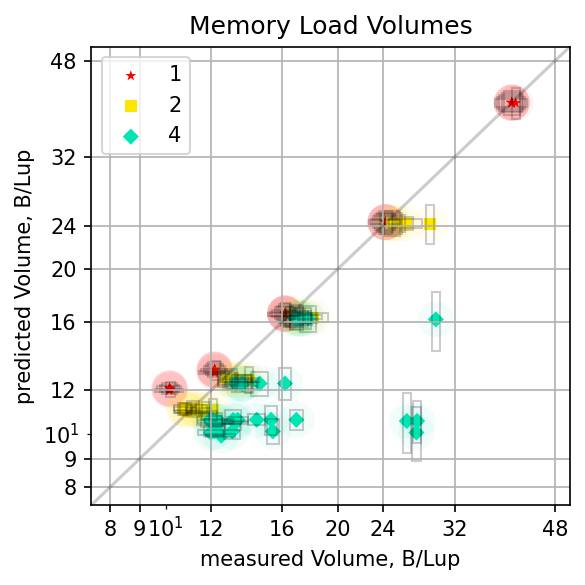

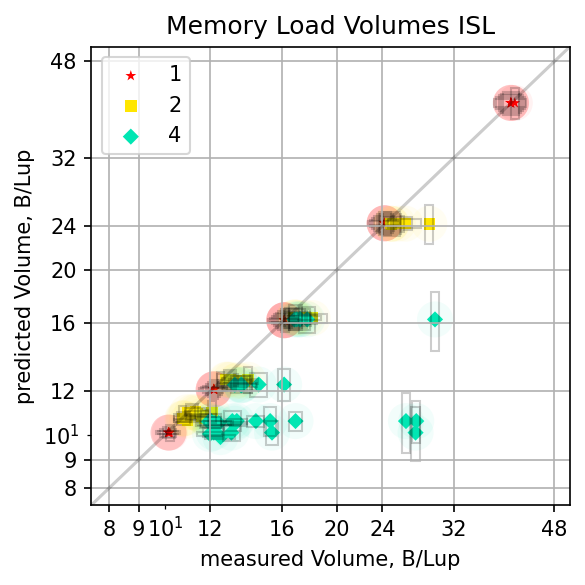

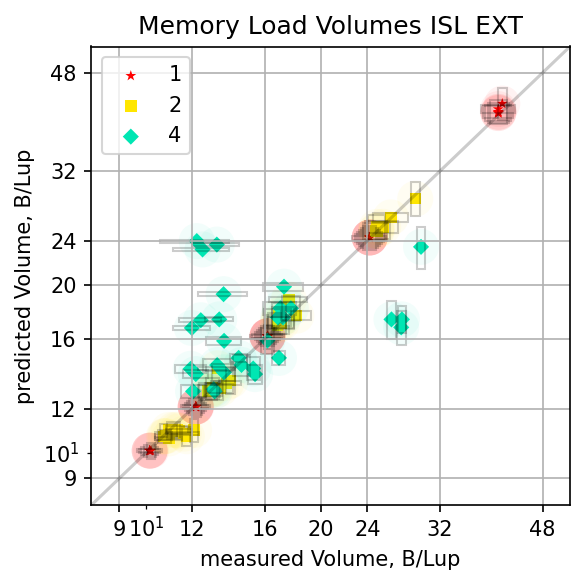

In [12]:
volumeScatterPlot(getArray("mMemLoad"), getArray("pMemLoad"), "Memory Load Volumes")
volumeScatterPlot(getArray("mMemLoad"), getArray("pMemLoadISL"), "Memory Load Volumes ISL")
volumeScatterPlot(getArray("mMemLoad"), getArray("pMemLoadISLext"), "Memory Load Volumes ISL EXT")

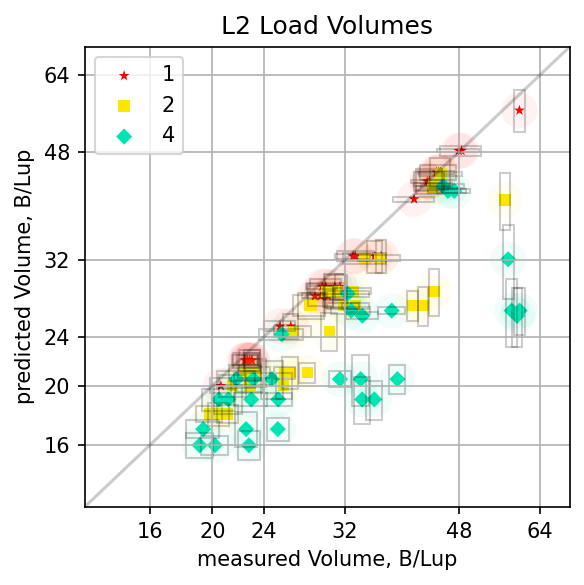

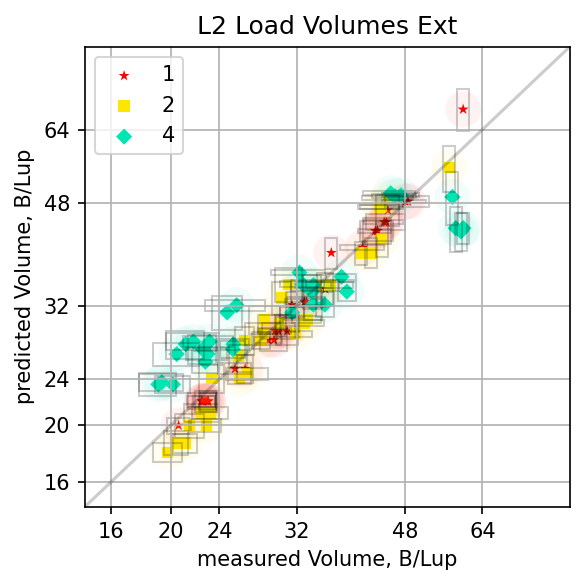

In [13]:
volumeScatterPlot(getArray("mL2Load"), getArray("pL2Load"), "L2 Load Volumes")
volumeScatterPlot(getArray("mL2Load"), getArray("pL2LoadExt"), "L2 Load Volumes Ext")


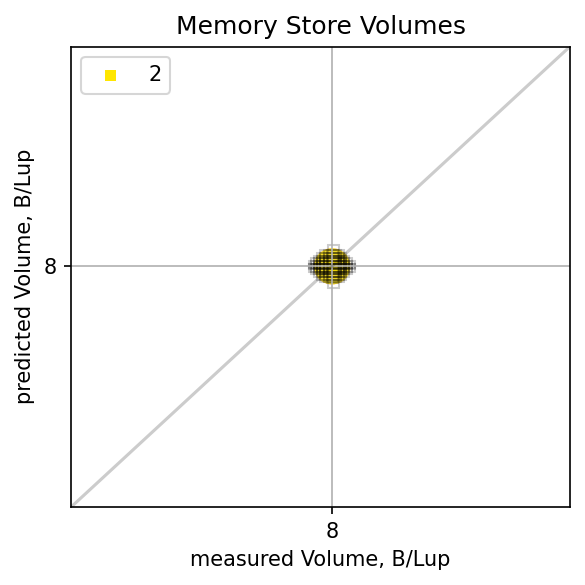

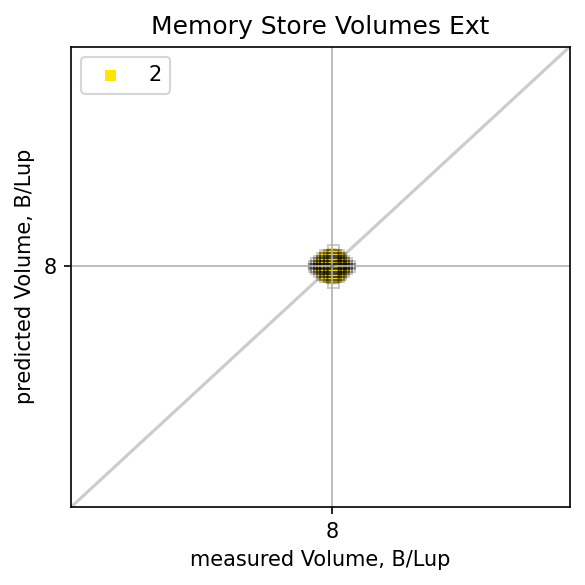

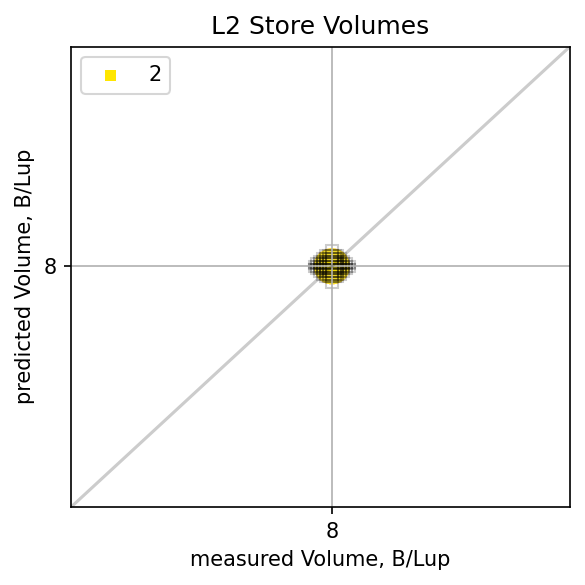

In [14]:
volumeScatterPlot({key: v["memStore"] for key, v in measValues.items()}, {key: v["memStore"] for key, v in predValues.items()}, "Memory Store Volumes")
volumeScatterPlot({key: v["memStore"] for key, v in measValues.items()}, {key: v["memStoreExt"] for key, v in predValues.items()}, "Memory Store Volumes Ext")
volumeScatterPlot({key: v["L2Store"] for key, v in measValues.items()}, {key: v["L2Store"] for key, v in predValues.items()}, "L2 Store Volumes")